<a href="https://colab.research.google.com/github/mlxyz/32474-blob-storage-ios-repro/blob/master/3_1_classification_with_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Classification</h1>

In this exercise session we'll be taking a closer look at classification algorithms. To recap, *classification* refers to the prediction of a **discrete** target variable (e.g. detecting dog breeds from images) while *regression* describes the prediction of a **continuous** variable.

![](https://static.javatpoint.com/tutorial/machine-learning/images/regression-vs-classification-in-machine-learning.png)

# Download & Load Data

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('https://exercisesmlstorage.blob.core.windows.net/deep-learning/loan_classification.csv')

# Data Exploration, Visualization & Preprocessing, Preparation (Repetition)

We first take a look at 10 random rows from the dataset to get an understanding of what is contained:

In [ ]:
df.sample(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
140,LP001994,Female,No,0,Graduate,No,2400,1863.0,104.0,360.0,0.0,Urban,N
306,LP002131,Male,Yes,2,Not Graduate,No,3083,2168.0,126.0,360.0,1.0,Urban,Y
717,LP002746,Male,No,0,Graduate,No,5314,0.0,147.0,360.0,1.0,Urban,NaN
444,LP002054,Male,Yes,2,Not Graduate,No,3601,1590.0,NaN,360.0,1.0,Rural,Y
542,LP002394,Male,Yes,2,Graduate,No,4010,1025.0,120.0,360.0,1.0,Urban,NaN
958,LP002582,Female,No,0,Not Graduate,Yes,17263,0.0,225.0,360.0,1.0,Semiurban,Y
51,LP002102,Male,Yes,0,Graduate,Yes,1900,1442.0,88.0,360.0,1.0,Rural,NaN
284,LP002487,Male,Yes,0,Graduate,No,3015,2188.0,153.0,360.0,1.0,Rural,Y
1,LP001607,Female,No,0,Not Graduate,No,0,1760.0,180.0,360.0,1.0,Semiurban,NaN
240,LP002107,Male,Yes,3+,Not Graduate,No,2855,542.0,90.0,360.0,1.0,Urban,NaN


The dataset has the following columns:

Variable | Description
----------|--------------
Loan_ID | Unique Loan ID
Gender | Male/ Female
Married | Applicant married (Y/N)
Dependents | Number of dependents
Education | Applicant Education (Graduate/ Under Graduate)
Self_Employed | Self employed (Y/N)
ApplicantIncome | Applicant income
CoapplicantIncome | Coapplicant income
LoanAmount | Loan amount in thousands
Loan_Amount_Term | Term of loan in months
Credit_History | credit history meets guidelines
Property_Area | Urban/ Semi Urban/ Rural
Loan_Status | Loan approved (Y/N)


Our goal here is to build a model that can predict whether a loan is approved or not given the other features.

## Cleansing

Let's check how complete our dataset is:

In [ ]:
df.isna().sum()

Loan_ID                0
Gender                24
Married                3
Dependents            25
Education              0
Self_Employed         55
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount            27
Loan_Amount_Term      20
Credit_History        79
Property_Area          0
Loan_Status          367
dtype: int64

We do have some null values so let's fix that by just dropping the corresponding rows:

In [ ]:
df = df.dropna()

Regarding duplicate values, we can verify that we don't have any duplicate rows:

In [ ]:
df.duplicated(subset=['Loan_ID']).any()

False

One additional cleansing step we might do is dropping the `Loan_ID` column as that does not contain any additional information:

In [ ]:
df = df.drop(columns='Loan_ID')

## Exploration

For data exploration, we can first get info about the data types of all columns using the `info()` function:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 2 to 980
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             480 non-null    object 
 1   Married            480 non-null    object 
 2   Dependents         480 non-null    object 
 3   Education          480 non-null    object 
 4   Self_Employed      480 non-null    object 
 5   ApplicantIncome    480 non-null    int64  
 6   CoapplicantIncome  480 non-null    float64
 7   LoanAmount         480 non-null    float64
 8   Loan_Amount_Term   480 non-null    float64
 9   Credit_History     480 non-null    float64
 10  Property_Area      480 non-null    object 
 11  Loan_Status        480 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 48.8+ KB


And the calculate some statistics for numerical columns: 

In [ ]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,480.000000,480.000000,480.000000,480.000000,480.000000
mean,5364.231250,1581.093583,144.735417,342.050000,0.854167
std,5668.251251,2617.692267,80.508164,65.212401,0.353307
min,150.000000,0.000000,9.000000,36.000000,0.000000
25%,2898.750000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1084.500000,128.000000,360.000000,1.000000
75%,5852.500000,2253.250000,170.000000,360.000000,1.000000
max,81000.000000,33837.000000,600.000000,480.000000,1.000000


## Categorical Data Encoding

We do have categorical data (both nominal and ordinal), so for data pre-processing, we will encode the categorical nominal columns by using the `pd.get_dummies` function. We're not using the `LabelEncoder` as it gives the same result for cases with two columns if we drop one of the columns of the value returned by the `pd.get_dummies` function.

In [ ]:
df = pd.concat([
    df.drop(columns=['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']), # remove the columns we one-hot-encode
    pd.get_dummies(df.Gender, drop_first=True, prefix='Gender'),
    pd.get_dummies(df.Married, drop_first=True, prefix='Married'),
    pd.get_dummies(df.Education, drop_first=True, prefix='Education'),
    pd.get_dummies(df.Self_Employed, drop_first=True, prefix='Self_Employed'),
    pd.get_dummies(df.Loan_Status, drop_first=True, prefix='Loan_Status'),
], axis=1) # join the one-hot-encoded columns by concatenating them side-by-side (axis 1)

We only have two columns containing ordinal data, so we encode them following the `mapping` approach we saw last time:

In [ ]:
dependents_mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3+': 3
}
df.Dependents = df.Dependents.apply(lambda x: dependents_mapping[x])

In [ ]:
property_area_mapping = {
    'Rural': 0,
    'Semiurban': 1,
    'Urban': 2,
}
df.Property_Area = df.Property_Area.apply(lambda x: property_area_mapping[x])

Now that we have encoded all categorical columns, we can also verify that we only have numerical columns left:

In [ ]:
df.dtypes

Dependents                  int64
ApplicantIncome             int64
CoapplicantIncome         float64
LoanAmount                float64
Loan_Amount_Term          float64
Credit_History            float64
Property_Area               int64
Gender_Male                 uint8
Married_Yes                 uint8
Education_Not Graduate      uint8
Self_Employed_Yes           uint8
Loan_Status_Y               uint8
dtype: object

## Scaling

We conduct feature scaling on all of our columns (as the ranges of values are quite different between columns) and store this in a new `df_scaled` dataframe.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
columns_to_scale = list(set(df.columns) - {'Loan_Status_Y'}) # take all columns except Loan_Status_Y
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

We can now see that the statistics are quite different between the non-scaled and scaled version:

In [ ]:
df.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Loan_Status_Y
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.777083,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.820833,0.647917,0.202083,0.137500,0.691667
std,1.020815,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.383892,0.478118,0.401973,0.344734,0.462287
min,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,2.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_scaled.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Loan_Status_Y
count,480.000000,4.800000e+02,4.800000e+02,4.800000e+02,4.800000e+02,4.800000e+02,4.800000e+02,4.800000e+02,4.800000e+02,4.800000e+02,4.800000e+02,480.000000
mean,0.000000,2.960595e-17,2.960595e-17,-1.776357e-16,-1.813364e-16,7.031412e-17,-6.661338e-17,5.551115e-18,-6.568820e-17,-1.184238e-16,1.480297e-17,0.691667
std,1.001043,1.001043e+00,1.001043e+00,1.001043e+00,1.001043e+00,1.001043e+00,1.001043e+00,1.001043e+00,1.001043e+00,1.001043e+00,1.001043e+00,0.462287
min,-0.762033,-9.208610e-01,-6.046330e-01,-1.687742e+00,-4.698022e+00,-2.420153e+00,-1.318868e+00,-2.140419e+00,-1.356553e+00,-5.032531e-01,-3.992747e-01,0.000000
25%,-0.762033,-4.354171e-01,-6.046330e-01,-5.562428e-01,2.755416e-01,4.131969e-01,-1.318868e+00,4.671982e-01,-1.356553e+00,-5.032531e-01,-3.992747e-01,0.000000
50%,-0.762033,-2.658318e-01,-1.899046e-01,-2.080892e-01,2.755416e-01,4.131969e-01,-2.954695e-02,4.671982e-01,7.371624e-01,-5.032531e-01,-3.992747e-01,1.000000
75%,1.199231,8.623086e-02,2.570423e-01,3.141413e-01,2.755416e-01,4.131969e-01,1.259774e+00,4.671982e-01,7.371624e-01,-5.032531e-01,-3.992747e-01,1.000000
max,2.179863,1.335768e+01,1.233512e+01,5.660787e+00,2.117602e+00,4.131969e-01,1.259774e+00,4.671982e-01,7.371624e-01,1.987072e+00,2.504541e+00,1.000000


## Visualization

We only do some very basic data visualization here by creating a frequency plot for all encoded columns and a histogram plot for all non-encoded columns:

We start by creating a list of all encoded and non-encoded columns:

In [ ]:
encoded_columns = ['Dependents','Credit_History', 'Property_Area', 'Gender_Male',
       'Married_Yes', 'Education_Not Graduate', 'Self_Employed_Yes',
       'Loan_Status_Y']
numerical_columns = list(set(df.columns) - set(encoded_columns))

Then we plot the values of each encoded column by first calculating the frequency of each value, sorting by the index (i.e. by the value) and then creating a bar plot: 

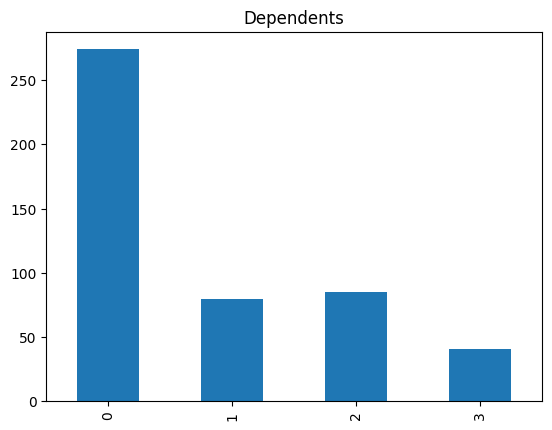

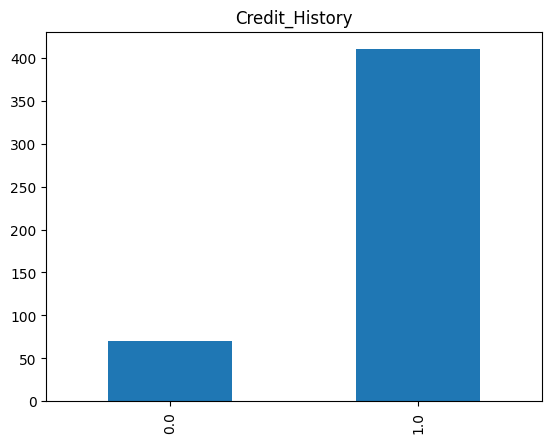

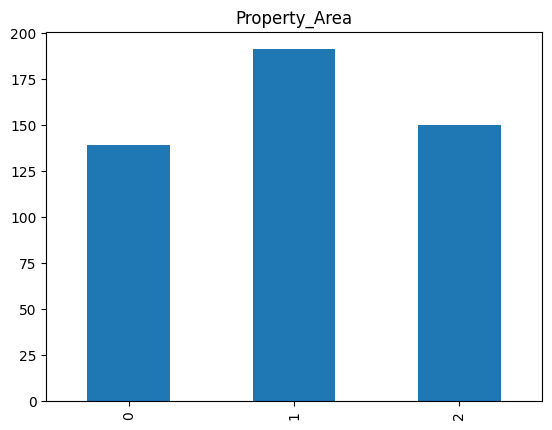

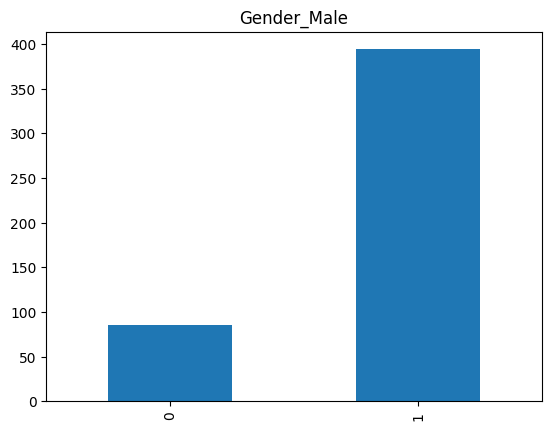

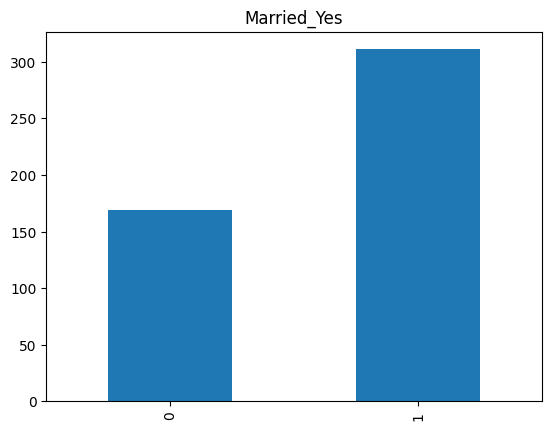

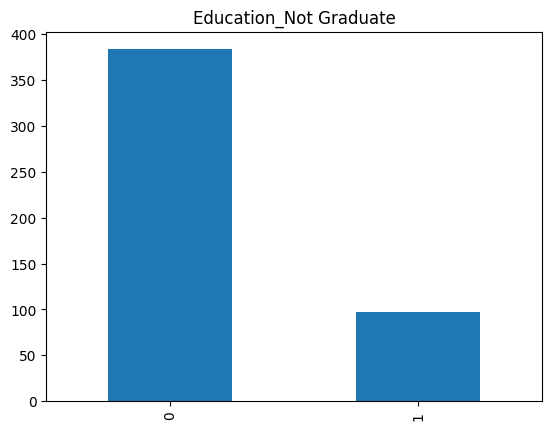

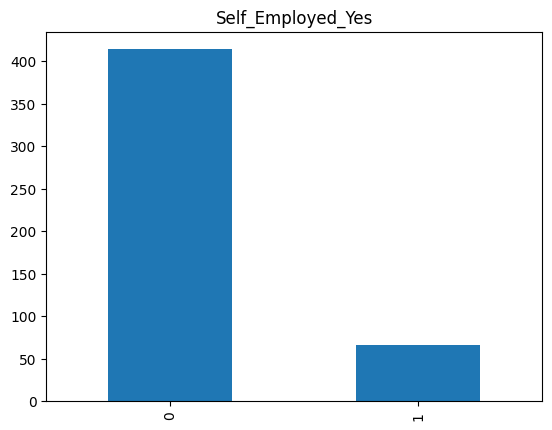

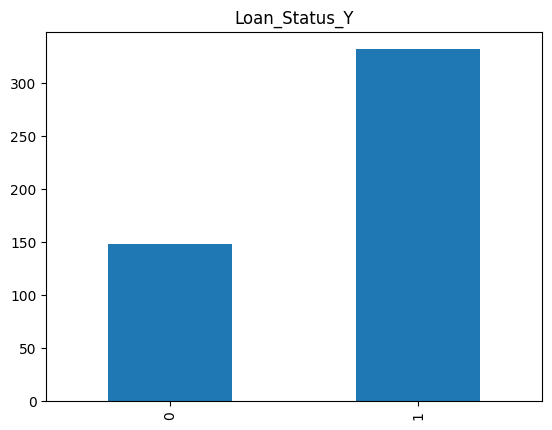

In [ ]:
import matplotlib.pyplot as plt
for column in encoded_columns:
  fig = plt.figure() # required if we want to plot multiple figures from the same cell
  df[column].value_counts(sort=False).sort_index().plot(kind='bar', title=column)

For the non-encoded columns, we can just create histogram plots directly:

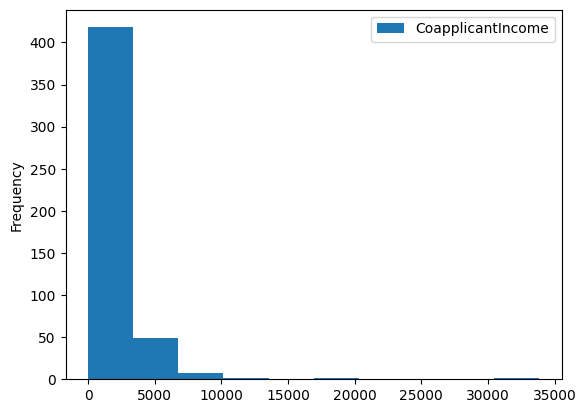

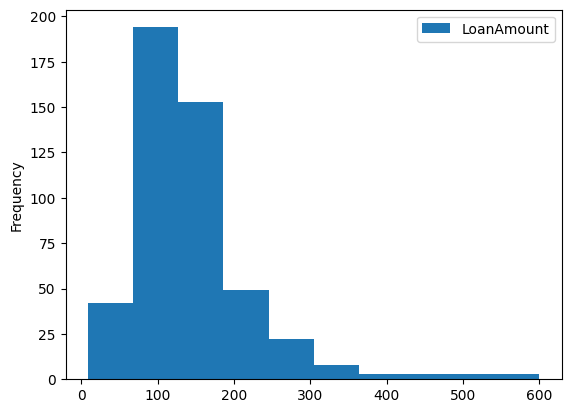

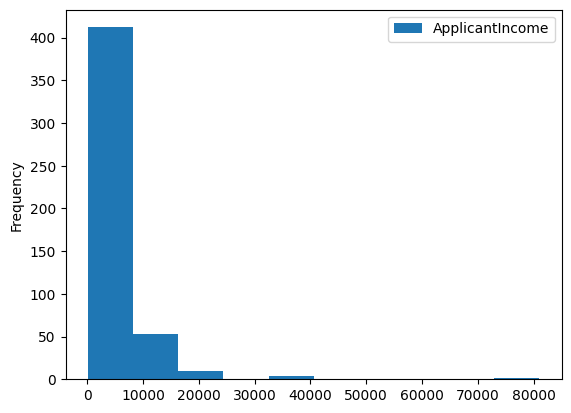

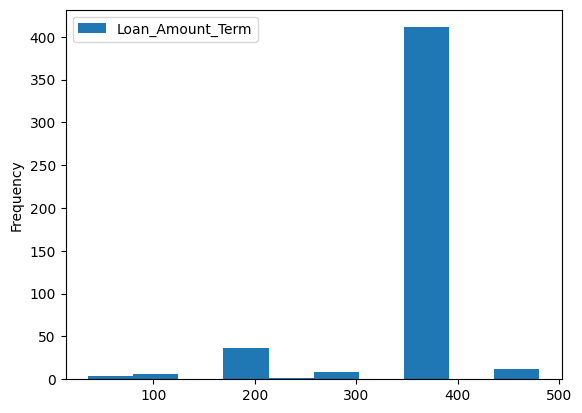

In [ ]:
for column in numerical_columns:
  df.plot(kind='hist', y=column)

Finally, we might also create a correlation heatmap which can show us the correlation between columns as follows:

<Axes: >

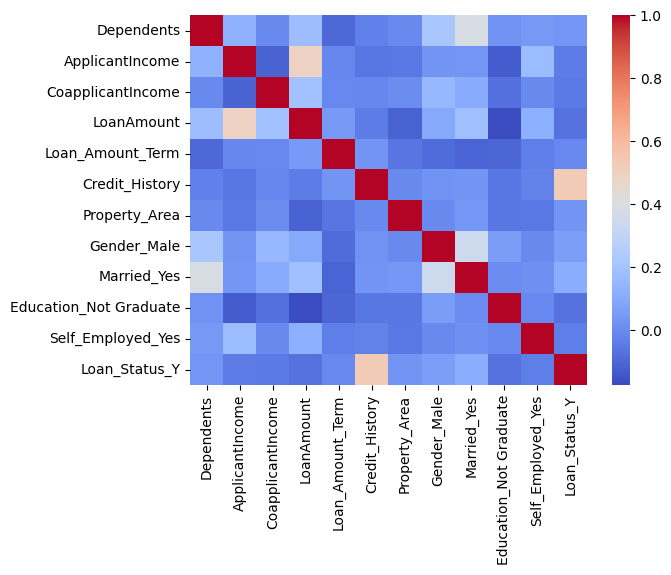

In [ ]:
import seaborn as sns
# .corr() calculates the correlation between each column in our dataframe
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')

If we consider the `Loan_Status_Y` column, we can see that the `Credit_History` expectedly has a pretty strong positive correlation.

Please note though that this is only the correlation strength, not the significance.

# Model Training & Evaluation

Before we start training ML models, we have to decide which columns we consider features and which column we consider the target variable.

In our case, we want to use all columns except for the `Loan_Status_Y` as we will be using this as the target variable.

In [ ]:
X = df.drop(columns='Loan_Status_Y')
y = df.Loan_Status_Y

In [ ]:
X_scaled = df_scaled.drop(columns='Loan_Status_Y')
y_scaled = df_scaled.Loan_Status_Y

Then, we split it into train and test sets (80/20) using a stratified split. This means that the class distribution is about equal in the training and testing subset.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, stratify = y_scaled, shuffle = True)

The train-test-split is important because we always want to evaluate our models on data it has not seen during training as that might distort results.

For model evaluation, we can create a small function outputting the sklearn classification report for a given estimator. The [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function gives you an overview of a models' overall performance and its performance on each class. It includes measures like accuracy, recall, precision and $F_1$.

In [ ]:
from sklearn.metrics import classification_report
def evaluate(clf, X_test, y_true):
  y_pred = clf.predict(X_test)
  print(classification_report(y_true, y_pred))

The `evaluate` function expects the model (`clf` for classifier), test dataset features (`X_test`) as well as the true underlying labels (`y_true`). It then generates predictions from the model and compares those to the target labels using the `classification_report` function.

Now that we have everything prepared, we can start training our models.

## $k$-NN Manual Implementation (optional)

![](https://datascientest.com/wp-content/uploads/2020/11/Illu-2-KNN-1024x492.jpg)

We'll start off with a $k$-NN model. However, to get a better understanding of how the $k$-NN algorithm works, we'll manually implement it using only numpy:

In [ ]:
import numpy as np
from tqdm.notebook import tqdm # tqdm is a small library for displaying progress bars

One of the most important aspects of any $k$-NN algorithm is the distance metric used to measure similarity between examples. We'll be using the standard euclidean distance which is defined as $d(p,q) = \sqrt{(p_1- q_1)^2 + (p_2 - q_2)^2+\cdots+(p_i - q_i)^2+\cdots+(p_n - q_n)^2}$

A common operation we have to do when applying the $k$-NN algorithm is to calculate the distance between one example in our test set and every example in our training data. We'll start by implementing a function which returns just that:

In [ ]:
def euclidian_distance(a, b):
  """Calculates the distance between 'a' (vector) to each example in 'b' (matrix)."""
  diff = a - b # row-wise diff
  square = np.square(diff) # element-wise square
  sum = np.sum(square, axis=1) # row-wise sum
  return np.sqrt(sum) # element-wise square

You'll notice that we are using the numpy broadcasting functionality quite a lot instead of relying on iterations. This is because broadcasting is highly optimized and runs a lot faster than simple `for` loops.

To understand the implementation, you just have to understand how numpy handles operations between arrays with different shapes. For example, in the first line of the implementation `diff = a - b` we are subtracting a matrix (`b`) from a vector (`a`). numpy will therefore apply this operation to each row in the matrix `a` as you can see here:

In [ ]:
np.asarray([1,2,3,4]) - np.asarray([[1,1,1,1],[2,2,2,2]])

array([[ 0,  1,  2,  3],
       [-1,  0,  1,  2]])

Let's try out our implementation and see what it returns:

In [ ]:
euclidian_distance(np.asarray([1,2,3,4,5]), np.asarray([[1,2,3,4,5], [2,3,4,5,6]]))

array([0.        , 2.23606798])

Now that we have a way of calculating similarity between examples, we can start implementing a function which outputs an array of the nearest neighbors for each example in the test set:

In [ ]:
def kneighbors(X_train, X_test, n_neighbors = 5):
  """Returns an array with the indices of the n most similar neighbors in X_train for each example in X_test."""
  dist = []
  neigh_ind = []
  
  print('Calculating distances...')
  # calculate the distance between every point in X_test with every point in X_train
  # every row in point_dist contains an array containing the distance of the respective X_test example with all examples in X_train 
  point_dist = [euclidian_distance(x_test, X_train) for x_test in tqdm(X_test)]

  print('Determining nearest neighbors..')
  # we iterate over the distance matrices of every example in X_test
  for row in tqdm(point_dist):
      enum_neigh = enumerate(row) # add index to each distance matrix

      # sort by distance and take top n_neighbors
      sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:n_neighbors]

      # get indices of n nearest neighbors
      ind_list = [tup[0] for tup in sorted_neigh]

      # get distances of n nearest neighbors
      # we actually don't need dist_list for our implementation
      # but if we wanted to weight our neighbors by distance we would also return this
      dist_list = [tup[1] for tup in sorted_neigh]

      # add row with indices and distances for this example
      dist.append(dist_list)
      neigh_ind.append(ind_list)
  
  return np.array(neigh_ind)

The implementation might seem a little bit complicated at first but if you go through it slowly thinking about what the shape of every variable is, it's actually quite straightforward.

Let's test our implementation:

In [ ]:
kneighbors(np.asarray([[1,2,3,4,5], [2,3,4,5,6], [3,4,5,6,7]]), np.asarray([[1,2,3,4,5], [2,3,4,5,6]]), 1)

Calculating distances...


  0%|          | 0/2 [00:00<?, ?it/s]

Determining nearest neighbors..


  0%|          | 0/2 [00:00<?, ?it/s]

array([[0],
       [1]])

As we expect, the first example in X_train is closest to the first example in X_test and the second example in X_train is closest to the second example in X_test.

Finally, we can implement a function performing the actual predictions:

In [ ]:
def predict(X_train, y_train, X_test):
  """Returns the predicted class for each example in X_test."""
  
  # get nearest neighbors for each example in X_test
  
  neighbors = kneighbors(X_train, X_test)
  print('Determining predicted class...')
  y_pred = np.array([
      np.argmax(np.bincount(y_train[neighbor])) # bin the result and take max class
      for neighbor in tqdm(neighbors) # iterate over all neighbors
  ])

  return y_pred

In this implementation, the line `np.argmax(np.bincount(y_train[neighbor]))` is key. `np.bincount` counts the number of occurrences of each value in an array:

In [ ]:
np.bincount(np.asarray([1,2,3,4,1,2,3,1,1,1]))

array([0, 5, 2, 2, 1])

As expected, we have 0 times `0`, 5 times `1` etc.

If we combine this function with `np.argmax` we get the number which appears most frequently in the array (i.e. our $k$-NN prediction):

In [ ]:
np.argmax(np.bincount(np.asarray([1,2,3,4,1,2,3,1,1,1])))

1

Now that we have everything for performing predictions, we can create a function for evaluating our model. The implementation is quite straightforward as we are relying on sklearns `classification_report` function:

In [ ]:
def score(X_train, y_train, X_test, y_test):
  y_pred = predict(X_train, y_train, X_test)
  y_true = y_test
  print(classification_report(y_true, y_pred))

Let's see how our model performs:

In [ ]:
score(np.array(X_train_scaled), np.array(y_train_scaled), np.array(X_test_scaled), np.array(y_test_scaled))

Calculating distances...


  0%|          | 0/96 [00:00<?, ?it/s]

Determining nearest neighbors..


  0%|          | 0/96 [00:00<?, ?it/s]

Determining predicted class...


  0%|          | 0/96 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.59      0.33      0.43        30
           1       0.75      0.89      0.81        66

    accuracy                           0.72        96
   macro avg       0.67      0.61      0.62        96
weighted avg       0.70      0.72      0.69        96



The model performs quite well as we achieve an $F_1$ score of 81% and an accuracy of 72%.

Also, right now we are using $k=5$, but that is probably not the best option. We would have to conduct hyperparameter tuning to find out which value for $k$ leads to the best results.

## $k$-NN

Let's check if $k$-NN really works that well or if it is just an effect of randomness by utilizing the $k$-NN implementation from scikit-learn.

Training a model with `scikit-learn` follows a fairly standard process:


1.   Import & instantiate the model
2.   Train the model on the training dataset using the `fit` function
3.   Evaluate the model
4.   Create predictions using the `predict` function



Let's start:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train_scaled, y_train_scaled)

KNeighborsClassifier()

Let's evaluate the model using our `evaluate` function:

In [ ]:
evaluate(knn, X_test_scaled, y_test_scaled)

              precision    recall  f1-score   support

           0       0.59      0.33      0.43        30
           1       0.75      0.89      0.81        66

    accuracy                           0.72        96
   macro avg       0.67      0.61      0.62        96
weighted avg       0.70      0.72      0.69        96



We achieve a very similar result.

If we wanted to improve the performance of our model, we could look at performing hyperparameter tuning, i.e. determining which hyperparameters work best for our dataset.


## Logistic Regression

Logistic regression is another model we might try for our dataset.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistic = LogisticRegression(random_state=42)

In [ ]:
logistic.fit(X_train_scaled, y_train_scaled)

LogisticRegression(random_state=42)

In [ ]:
evaluate(logistic, X_test_scaled, y_test_scaled)

              precision    recall  f1-score   support

           0       0.80      0.40      0.53        30
           1       0.78      0.95      0.86        66

    accuracy                           0.78        96
   macro avg       0.79      0.68      0.70        96
weighted avg       0.78      0.78      0.76        96



The model performs slightly better than $k$-NN as it achieves an $F_1$ of 86%. Again, we are not optimizing any hyperparameters here which **should** always be done when comparing the performance of different models. In our case however, we only want to understand how to apply these models.

## Decision Tree

We can also try a decision tree classifier.

![](https://forum.huawei.com/enterprise/en/data/attachment/forum/202103/24/190400o09x7rhnnhy2yon7.png?1.png)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier(random_state=42)

Note that for training decision trees, we do not use the scaled version as decision trees can easily deal with features of varying ranges. Also, using the unscaled version makes the interpretation much easier.

In [ ]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
evaluate(tree, X_test, y_test)

              precision    recall  f1-score   support

           0       0.56      0.47      0.51        30
           1       0.77      0.83      0.80        66

    accuracy                           0.72        96
   macro avg       0.67      0.65      0.66        96
weighted avg       0.71      0.72      0.71        96



It performs slightly worse than the other two models.

The good thing about decision trees is that they are really easy to interpret because they give us clear rules on how to classify any given example.

Let's plot the top leaves of the learned decision tree to find out which attributes are particularly important for the classification:

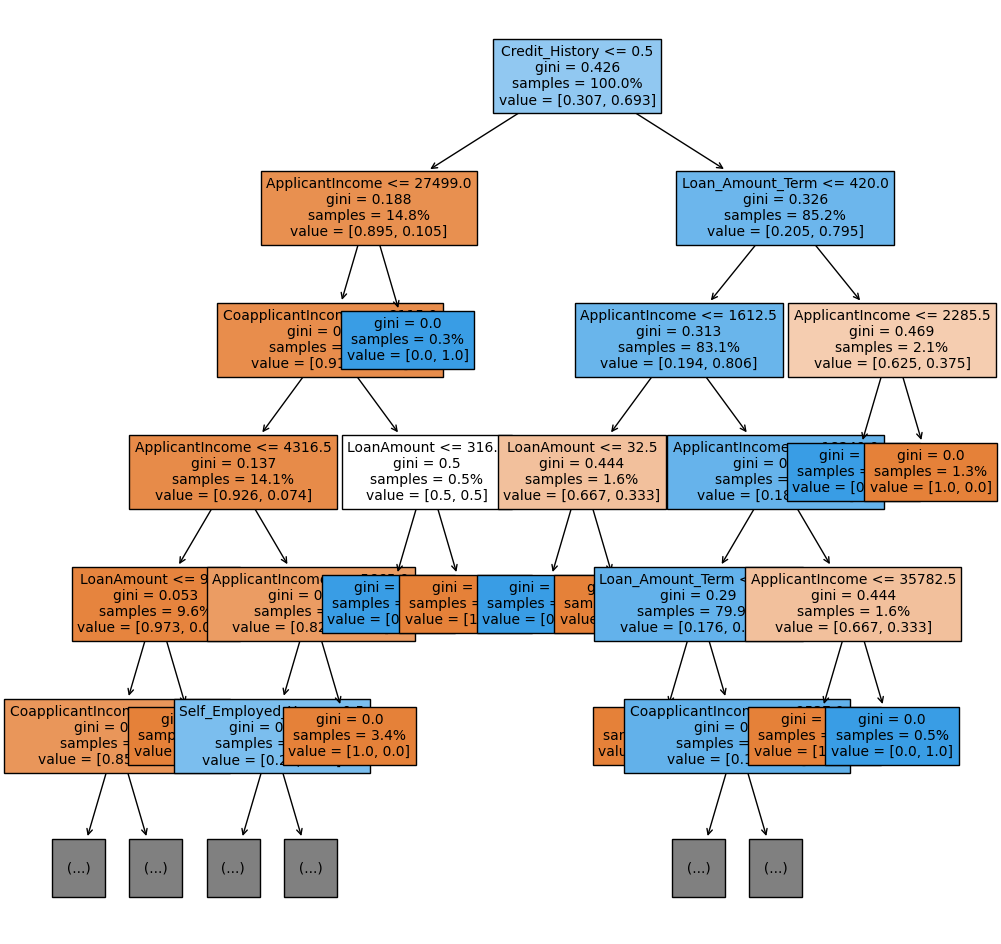

In [ ]:
from sklearn import tree as sktree
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12)) # increase figure size

sktree.plot_tree(tree, max_depth=5, fontsize=10, feature_names=X.columns, proportion=True, filled=True);

Looking at the plot, we can see that the decision tree makes the first distinction on whether the credit history meets the requirements or not. Apparently, that makes a big difference.

If it does not, then the `ApplicationIncome` seems to be the most important attribute with a turning point at around 27500$. If it does, the term of the loan seems to be important.

## Random Forest

Let's move on to a random forest classifier which basically is just a collection of decision trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
random_forest = RandomForestClassifier(random_state=42)

In [ ]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
evaluate(random_forest, X_test, y_test)

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        30
           1       0.77      0.91      0.83        66

    accuracy                           0.75        96
   macro avg       0.72      0.65      0.67        96
weighted avg       0.74      0.75      0.73        96



The random forest model performs pretty well with an $F_1$ score of 83%. However, as said before, we can't really make an informed statement about the performance of a model without performing hyperparameter optimization.

## XGBoost

Finally, we apply a boosting algorithm which is commonly applied and usually has quite good performance.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
xgb = GradientBoostingClassifier()

In [ ]:
xgb.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
evaluate(xgb, X_test, y_test)

              precision    recall  f1-score   support

           0       0.74      0.47      0.57        30
           1       0.79      0.92      0.85        66

    accuracy                           0.78        96
   macro avg       0.76      0.70      0.71        96
weighted avg       0.77      0.78      0.77        96



We can see that the boosting model again performs best with an $F_1$ score of 85%.

## Hyperparameter Tuning

As discussed before, to properly train models, we have to determine the optimal hyperparameters using a process called hyperparameter tuning. This basically involves trying out different sets of hyperparameters and settling on those that achieve the highest performance.

Fortunately, we can use the `RandomizedSearchCV` class for conducting hyperparam tuning:

For this, we first have to define our hyperparam grid, i.e. the values we want to try:

In [ ]:
from scipy.stats import loguniform

param_grid = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': loguniform(0.001, 1),
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Then we can create the class and conduct the training:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

ht = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, random_state=42, n_iter=100)

In [ ]:
ht.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7eff86d18be0>,
                                        'loss': ['log_loss', 'exponential'],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.5, 0.8, 1.0]},
                   random_state=42)

After training, we can then retrieve the optimal hyperparams:

In [ ]:
ht.best_params_

{'learning_rate': 0.026100256506134754,
 'loss': 'log_loss',
 'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 50,
 'subsample': 0.5}

And evaluate the best model (the model trained on the train dataset using the optimal hyperparameters):

In [ ]:
evaluate(ht, X_test, y_test)

              precision    recall  f1-score   support

           0       0.80      0.40      0.53        30
           1       0.78      0.95      0.86        66

    accuracy                           0.78        96
   macro avg       0.79      0.68      0.70        96
weighted avg       0.78      0.78      0.76        96



In this case, the hyperparam tuning did not improve the results.

# Error Analysis

We already have a general understanding of the performance of our models but we want to further explore in which areas they perform well and in which areas they perform badly.

The first thing we might do is plot a confusion matrix. It shows which classes the model predicts reliably and where it has problems:

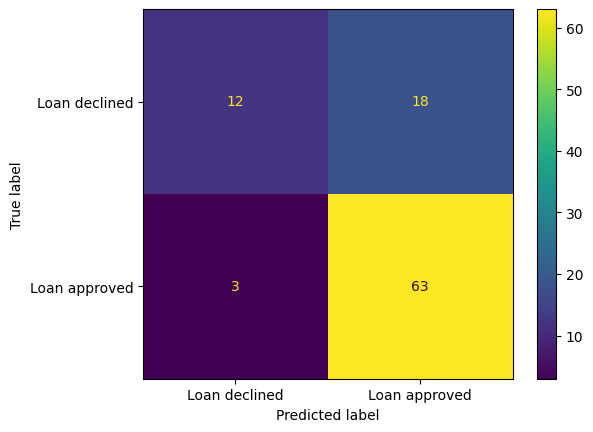

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    ht, X_test, y_test, labels=[0, 1], display_labels=['Loan declined', 'Loan approved'])

We can also manually look at the misclassified examples to see if there are any observations we can make:

Let's start by adding the predictions and target labels back to the original test dataset:

In [ ]:
predictions = ht.predict(X_test)
df_with_predictions = pd.concat([X_test, y_test], axis='columns')
df_with_predictions = pd.concat([df_with_predictions, pd.DataFrame(predictions, columns=['Prediction'], index=df_with_predictions.index)], axis=1)

Then, we filter on all rows where the prediction is unequal to the actual label:

In [ ]:
misclassified_df = df_with_predictions[df_with_predictions.Loan_Status_Y != df_with_predictions.Prediction]

In [ ]:
misclassified_df

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Loan_Status_Y,Prediction
888,0,9166,0.0,244.0,360.0,1.0,2,1,0,0,0,0,1
630,1,4583,1508.0,128.0,360.0,1.0,0,1,1,0,0,0,1
752,0,5726,4595.0,258.0,360.0,1.0,1,1,1,0,0,0,1
624,2,4566,0.0,100.0,360.0,1.0,2,1,1,0,0,0,1
712,3,5250,0.0,94.0,360.0,1.0,2,1,1,0,0,0,1
678,2,4923,0.0,166.0,360.0,0.0,1,1,0,0,0,1,0
758,0,5815,3666.0,311.0,360.0,1.0,0,1,0,0,0,0,1
11,0,1025,2773.0,112.0,360.0,1.0,0,1,1,0,0,1,0
511,1,3875,0.0,67.0,360.0,1.0,2,1,1,0,0,0,1
202,3,2647,1587.0,173.0,360.0,1.0,0,1,1,1,0,0,1


Now we can visually compare the misclassified examples to the original data by creating a side-by-side bar plot:

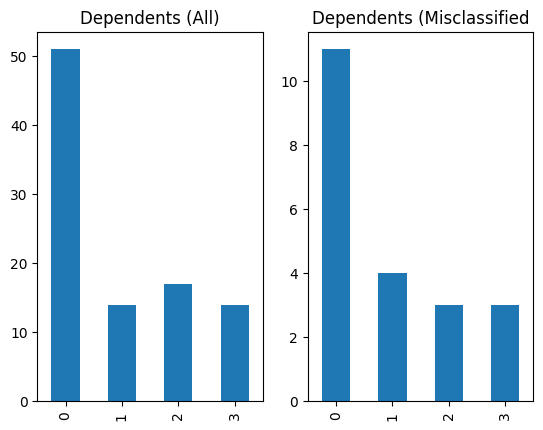

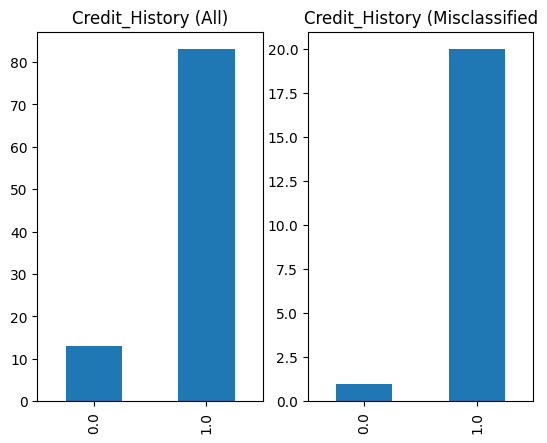

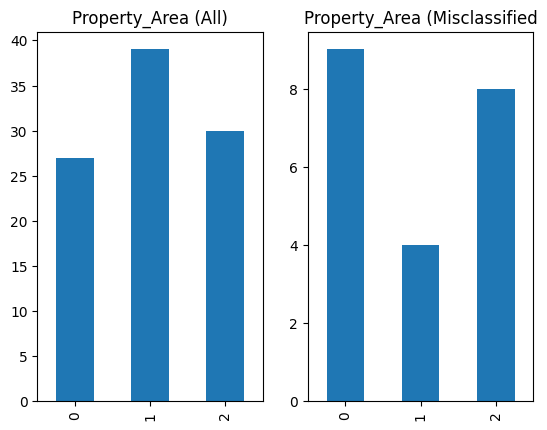

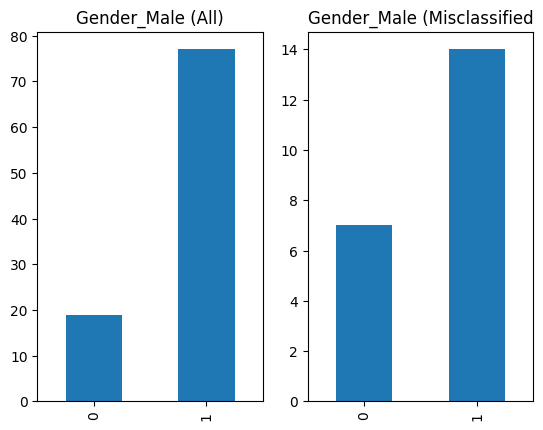

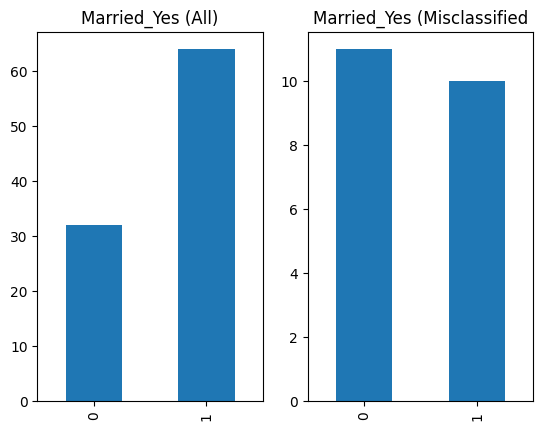

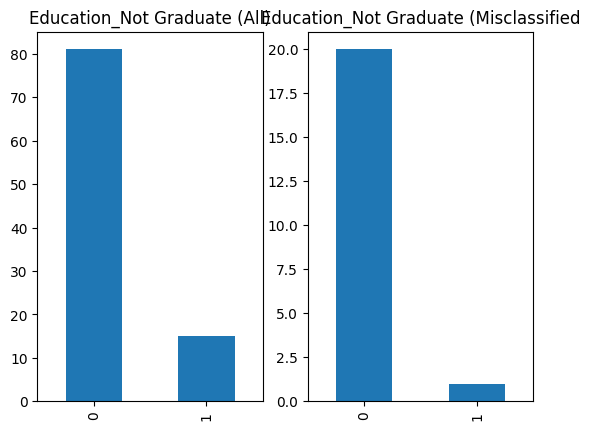

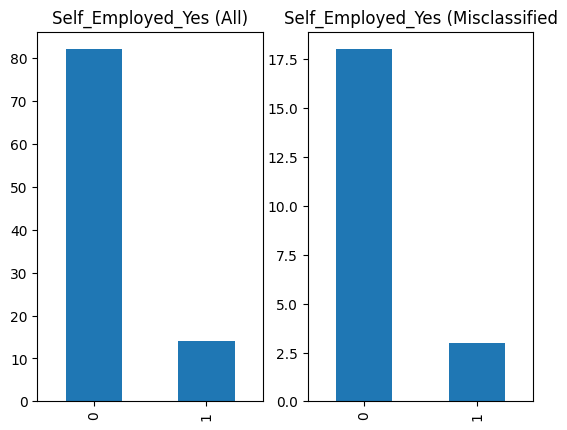

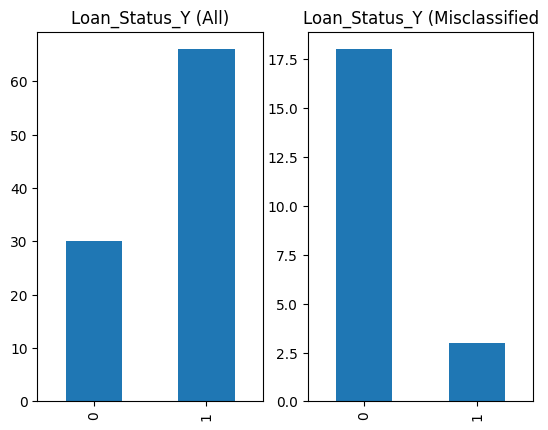

In [ ]:
import matplotlib.pyplot as plt
for column in encoded_columns:
  fig, (ax1, ax2) = plt.subplots(1, 2) # required if we want to plot multiple figures from the same cell
  df_with_predictions[column].value_counts(sort=False).sort_index().plot(kind='bar', title=f'{column} (All)', ax=ax1)
  misclassified_df[column].value_counts(sort=False).sort_index().plot(kind='bar', title=f'{column} (Misclassified)', ax=ax2)

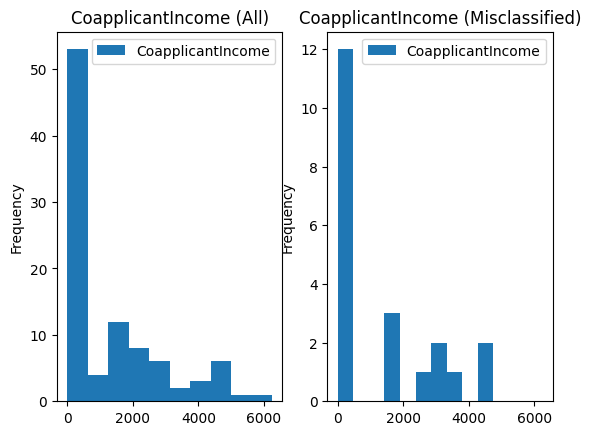

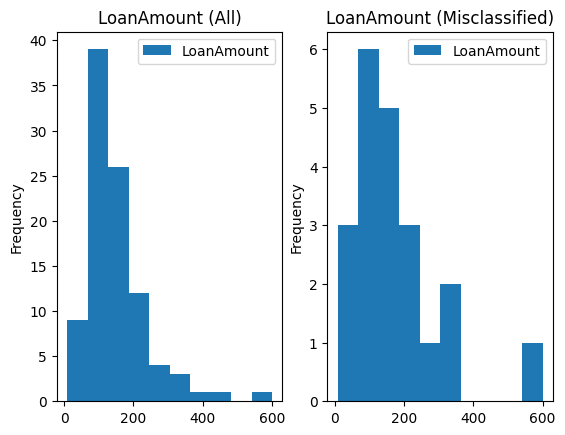

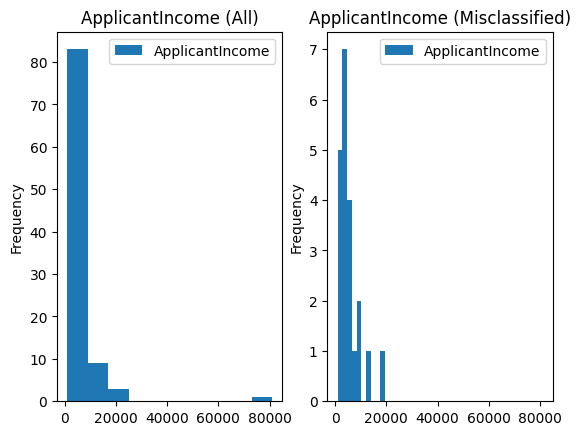

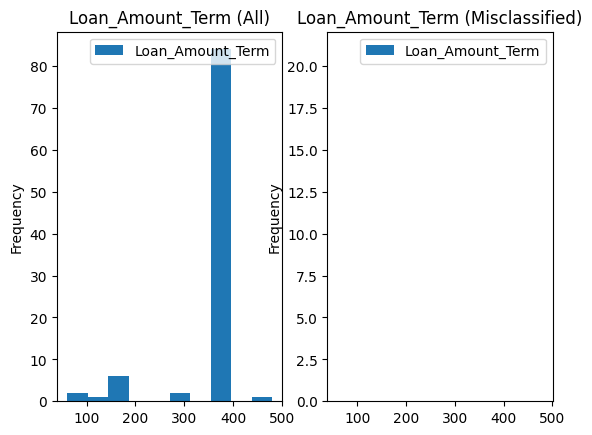

In [ ]:
for column in numerical_columns:
  fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
  df_with_predictions.plot(kind='hist', y=column, title=f'{column} (All)', ax=ax1)
  misclassified_df.plot(kind='hist', y=column, title=f'{column} (Misclassified)', ax=ax2)

We can see that the classifier is particularly bad at predicting the correct label for unmarried people but performs quite well on the suburban area. From these insights we could decide to gather more data on unmarried people to potentially improve model performance.

# Exercise

Use the breast cancer dataset from `https://exercisesmlstorage.blob.core.windows.net/deep-learning/breast_cancer.csv` and `https://exercisesmlstorage.blob.core.windows.net/deep-learning/breast_cancer_scaled.csv` (assume that the dataset is already completely cleansed & pre-processed) to train and evaluate a logistic regression model, a decision tree and a xgboost model. Conduct hyperparam tuning for the logistic regression and do some error analysis on the best logistic regression model (after hyperparam tuning).

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. 

| Attribute         | Description                                                     |
|-------------------|-----------------------------------------------------------------|
| ID number         | ID number                                                       |
| Diagnosis         | Diagnosis, where M = malignant and B = benign                   |
| radius            | Mean radius of distances from center to points on the perimeter |
| texture           | Standard deviation of gray-scale values                         |
| perimeter         | Perimeter                                                       |
| area              | Area                                                            |
| smoothness        | Local variation in radius lengths                               |
| compactness       | Perimeter^2 / area - 1.0                                        |
| concavity         | Severity of concave portions of the contour                     |
| concave points    | Number of concave portions of the contour                       |
| symmetry          | Symmetry                                                        |
| fractal dimension | "coastline approximation" - 1, also known as fractal dimension  |

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

In [ ]:
df = pd.read_csv('https://exercisesmlstorage.blob.core.windows.net/deep-learning/breast_cancer.csv')

In [ ]:
df_scaled = pd.read_csv('https://exercisesmlstorage.blob.core.windows.net/deep-learning/breast_cancer_scaled.csv')

In [ ]:
X = df.drop(columns='diagnosis')
y = df.diagnosis

In [ ]:
X_scaled = df_scaled.drop(columns='diagnosis')
y_scaled = df_scaled.diagnosis

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, stratify = y_scaled, shuffle = True)

In [ ]:
logistic = LogisticRegression(random_state=42)
logistic.fit(X_train_scaled, y_train_scaled)
evaluate(logistic, X_test_scaled, y_test_scaled)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [ ]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
evaluate(tree, X_test, y_test)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        72
           1       0.90      0.90      0.90        42

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



In [ ]:
xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)
evaluate(xgb, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
param_grid = {
    'C': loguniform(0.001, 1000),
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000],
}


In [ ]:
ht = RandomizedSearchCV(LogisticRegression(), param_grid, random_state=42, n_iter=100)
ht.fit(X_train_scaled, y_train_scaled)
evaluate(ht, X_test_scaled, y_test_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



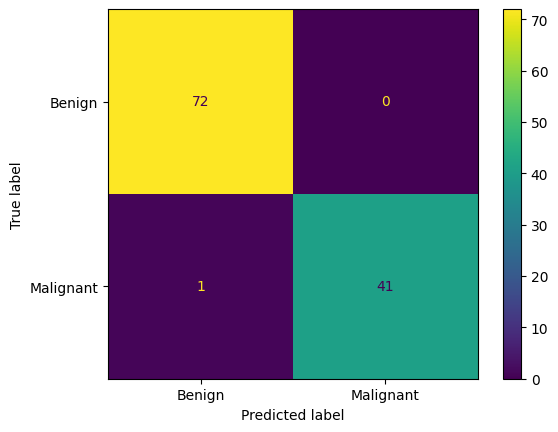

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    ht, X_test_scaled, y_test_scaled, labels=[0, 1], display_labels=['Benign', 'Malignant'])

# Wrap-Up

We've finished our tutorial session on classification!

You should be able to apply various standard classification algorithms using the sklearn library to a dataset consisting of (mostly) numerical attributes.

The next exercise session will deal with regression - i.e. the prediction of a continuous variable.

# Additional Resources



*   [Classifier Comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
*   [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)
*   [Post pruning decision trees](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)
